In [1]:
import datalab.bigquery as bq
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import tensorflow as tf
print tf.__version__
import os

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.7.0


In [2]:
PROJECT = 'go-de-internal'
BUCKET = 'go-de-internal-johanna'
REGION = 'europe-west1'
REPO = "/content/datalab/demo-cases/churn-prediction/lstm"
os.listdir(REPO)

['check.csv',
 'lstm.ipynb',
 'lstm 2.0.ipynb',
 'intermediate.csv',
 'churn_100_customers.csv',
 'churn_100_customers_365_days.csv',
 '.ipynb_checkpoints',
 'data_sets',
 'churn-create-timedependent-data.ipynb',
 'churn-time-dependent-artificial-data.csv',
 'trainer',
 'lstm training.ipynb',
 'churn.ipynb']

In [3]:
# for bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['REPO'] = REPO

In [4]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [5]:
%bash
PROJECT_ID=$PROJECT
AUTH_TOKEN=$(gcloud auth print-access-token)
SVC_ACCOUNT=$(curl -X GET -H "Content-Type: application/json" \
    -H "Authorization: Bearer $AUTH_TOKEN" \
    https://ml.googleapis.com/v1/projects/${PROJECT_ID}:getConfig \
    | python -c "import json; import sys; response = json.load(sys.stdin); \
    print response['serviceAccount']")

echo "Authorizing the Cloud ML Service account $SVC_ACCOUNT to access files in $BUCKET"
gsutil -m defacl ch -u $SVC_ACCOUNT:R gs://$BUCKET
gsutil -m acl ch -u $SVC_ACCOUNT:R -r gs://$BUCKET  # error message (if bucket is empty) can be ignored
gsutil -m acl ch -u $SVC_ACCOUNT:W gs://$BUCKET

Authorizing the Cloud ML Service account service-462605511119@cloud-ml.google.com.iam.gserviceaccount.com to access files in go-de-internal-johanna


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   133    0   133    0     0    136      0 --:--:-- --:--:-- --:--:--   136
No changes to gs://go-de-internal-johanna/
No changes to gs://go-de-internal-johanna/churn-prediction/
No changes to gs://go-de-internal-johanna/churn-prediction/lstm/
No changes to gs://go-de-internal-johanna/churn-prediction/lstm/a_b
No changes to gs://go-de-internal-johanna/churn-prediction/lstm/a_b/
No changes to gs://go-de-internal-johanna/churn-prediction/lstm/a_b/a_b.csv
No changes to gs://go-de-internal-johanna/churn-prediction/neural_net/churn-einzelhandel-train.csv
No changes to gs://go-de-internal-johanna/churn-prediction/neural_net/churn_trained/churn_model.hdf5
No changes to gs://go-de-internal-johanna/churn-prediction/neural_net/churn_trained/export/saved_model.pb
No changes to gs://go-de-internal-johanna/churn-prediction/mv_ab_model_ads_b

In [ ]:
!cat trainer/model.py

In [11]:
%bash
head -1 $REPO/labels.csv
head -1 $REPO/training.csv

0
,0,1,2,3,4


In [ ]:
from google.cloud import storage

DATA_BUCKET='go-de-internal-johanna'
FILES = ['training.csv', 'labels.csv']

client = storage.Client(project=PROJECT)
bucket = client.get_bucket(DATA_BUCKET)

for filename in FILES:
    with open(filename, 'wb') as f:
        bucket.blob(filename).download_to_file(f)

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

training = pd.read_csv('training.csv')
labels = pd.read_csv('labels.csv')
training = training.iloc[:,1:] #  remove useless first column
n_users = 10
n_seq = training.shape[0]/n_users
n_features = training.shape[1]
y = np.array(labels)
X = np.array(training).reshape(n_users, n_seq, n_features)
X_train, X_eval, y_train, y_eval = train_test_split(X, y)

In [55]:
import cPickle as pickle

FILES = ['X_train.pkl', 'X_eval.pkl', 'y_train.pkl', 'y_eval.pkl']
ARRAYS = [X_train, X_eval, y_train, y_eval]
for idx, filename in enumerate(FILES):
    with open("pickels/"+filename, 'wb') as f:
        pickle.dump(ARRAYS[idx], f)

## Compile Model:
Note the Stacked LSTMs...

In [56]:
!pip install keras

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [57]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

def model_fn(
    n_seq, n_features, 
    lstm1_nodes=10, lstm2_nodes=10, mlp1_nodes=10
):
    model = Sequential()
    model.add(LSTM(lstm1_nodes, input_shape=(n_seq, n_features), return_sequences=True))
    model.add(LSTM(lstm2_nodes))
    model.add(Dense(mlp1_nodes, activation='relu', name='last_layer'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
    )
    
    return model

## Train Model Locally:

In [67]:
BATCH_SIZE = 64


model = model_fn(X.shape[1], X.shape[2])
model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE, epochs=3,
    validation_data=(X_eval, y_eval)
)

Train on 7 samples, validate on 3 samples
Epoch 1/3
7/7 [==============================] - 5s 662ms/step - loss: 0.6918 - acc: 0.7143 - val_loss: 0.6934 - val_acc: 0.3333
Epoch 2/3
7/7 [==============================] - 1s 147ms/step - loss: 0.6866 - acc: 0.4286 - val_loss: 0.6936 - val_acc: 0.3333
Epoch 3/3
7/7 [==============================] - 1s 142ms/step - loss: 0.6836 - acc: 0.5714 - val_loss: 0.6941 - val_acc: 0.3333


## Score Model:

In [68]:
score = model.evaluate(X_eval, y_eval, batch_size=16)
print("eval accuracy: %0.3f" % score[1])

3/3 [==============================] - 0s 42ms/step
eval accuracy: 0.333


## Make a Prediction Locally:

In [69]:
y_hat = model.predict(X_eval, verbose=1)

3/3 [==============================] - 1s 234ms/step


## Interpretation:
How varied are the eval predictions?

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.49857926, 0.49858042, 0.49858158, 0.49858273, 0.49858389,
        0.49858505, 0.4985862 , 0.49858736, 0.49858851, 0.49858967,
        0.49859083]),
 <a list of 10 Patch objects>)

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


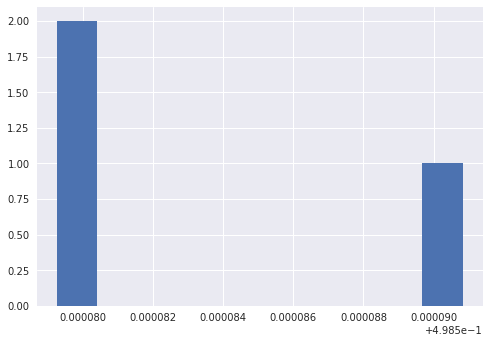

In [71]:
#%matplotlib inline
import matplotlib.pylab as plt
plt.hist(np.ravel(y_hat))

Data balance is an issue here.

### Is there structure in the second last layer?
If yes, we can pick out the event sequences characteristic of churn!

In [72]:
from sklearn.manifold import TSNE
from keras.models import Model

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer("last_layer").output)
intermediate_output = intermediate_layer_model.predict(X_eval, batch_size=BATCH_SIZE)

tsne = TSNE(perplexity=14, n_iter=1000)
tsne_output = tsne.fit_transform(intermediate_output)

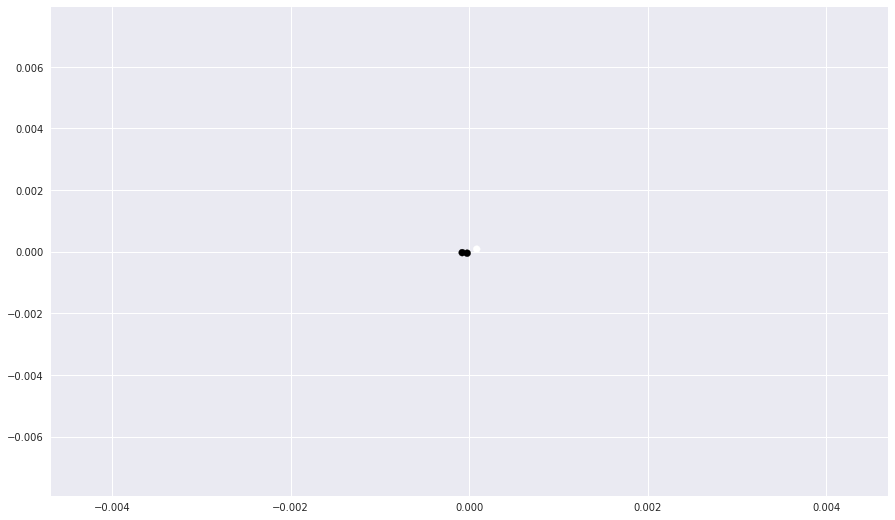

In [73]:
plt.figure(figsize=(15,9))
plt.scatter(tsne_output[:,0], tsne_output[:,1], c=y_eval[:,0], marker='o')

## Deploy model trained above in the cloud:
### Save model as pb file:

In [74]:
from customerbehaviour.reply.util import to_savedmodel
to_savedmodel(model, "./export_dir")

ImportError: No module named customerbehaviour.reply.util

### Deploy your locally trained model to CloudML!!!!!:
This can take a few minutes...

In [75]:
%%bash
MODEL_NAME=LSTM1
MODEL_BINARIES=./export_dir
STAGING_BUCKET=reply-jumpstart

gcloud ml-engine models create $MODEL_NAME --regions us-central1
gcloud ml-engine versions create v1 --model $MODEL_NAME \
    --origin $MODEL_BINARIES \
    --runtime-version 1.2 \
    --staging-bucket gs://$STAGING_BUCKET

Created ml engine model [projects/go-de-internal/models/LSTM1].
ERROR: (gcloud.ml-engine.versions.create) [./export_dir] is not a valid directory.


## Train the Model in CloudML:
### Two analogous examples:
#### Census training example:

In this instance, there are two examples of working machine learning jobs. They can both be run locally and in the cloud.

To access the census example run commands:
```
sudo su aloosley
cd ~/mkt-cloudml-jumpstart/clean_teaching_space/cloudml_examples/census
```

The commands you need to run these examples are in CLOUD_ML_BASH_CMDS.txt (In the cloud deploymend hyperparameter tuning is activated - to loose hyperparameter tuning, simply loose the codeline running it.)

Let's just first set all the environment variables we'll need later:

local params: 
```
EVAL_FILE=adult.test.csv
TRAIN_FILE=adult.data.csv
JOB_DIR=./results
TRAIN_STEPS=2
NUM_EPOCHS=2
```

cloud params:
```
GCS_TRAIN_FILE=gs://cloudml-public/census/data/adult.data.csv
GCS_EVAL_FILE=gs://cloudml-public/census/data/adult.test.csv
JOB_NAME=example_run_for_demo_census
JOB_DIR_GS=gs://example_bucket_for_demo_census/results
HPTUNING_CONFIG=hptuning_config.yaml
TRAIN_STEPS=200
```

Note: The JOB_DIR_GS has to exist.

If you haven't already, activate the python2 environment we've created for using cloudML:
```
source activate py2
```

Completely test the model locally before deplying a job to the cloud. Use a small number of epochs if you want.
Local Command:
```
python -m trainer.task --train-files $TRAIN_FILE \
                       --eval-files $EVAL_FILE \
                       --job-dir $JOB_DIR \
                       --train-steps $TRAIN_STEPS \
                       --num-epochs $NUM_EPOCHS
```

When it works fully from start to finish, you're ready to train in the cloud:
```
gcloud ml-engine jobs submit training $JOB_NAME \
                                    --stream-logs \
                                    --runtime-version 1.2 \
                                    --job-dir $JOB_DIR_GS \
                                    --package-path trainer \
                                    --module-name trainer.task \
                                    --region us-central1 \
                                    -- \
                                    --train-files $GCS_TRAIN_FILE \
                                    --eval-files $GCS_EVAL_FILE \
                                    --train-steps $TRAIN_STEPS
```

Note: you can detach from the job (ctrl + c), it will stay active. To reconnect
```
gcloud ml-engine jobs describe <JOB_NAME>
```

#### On Hyperparamentertuning:
When you add your own model for the hyperparameter tuning to run you need to make adjustments in the trainerpackage and hptuning_config.yaml.
```
cd trainer
nano model.py
```

All hyperparameters one might want to tune must be passed as keyword arguments in the model function (`model_fn`).  In this example, we will tune `hidden_nodes_in_layer_1` and `dropout_1`.

```
nano task.py
```

Each hyperparameter one wants to tune should be added to the arg-parser.  For example:
```
parser.add_argument(
        '--hidden_nodes_in_layer_1', #name of layer
        type=int,
        default=100, #has to be set !important
        help='Number of hidden units in MLP layer 1')
parser.add_argument(
        '--dropout_1',
        type=float,
        default=0.5,
        help='Amount of dropout in the first layer')
```

Finally hptuning_config.yaml needs to know what the hyperparameters and their ranges are. 
```
cd ..
nano hptuning_config.yaml 
```

There are a few general things that can be adjusted:
```
trainingInput:
  hyperparameters:
    goal: MAXIMIZE #if you want to MINIMIZE..
    hyperparameterMetricTag: accuracy #can be changed
    maxTrials: 40 #number of test you "allow"
    maxParallelTrials: 2 number of parallel trials
```

Further for each hyperparameter to be defined, set type, minValue, maxValue, scaleType.

```
  params:
      - parameterName: hidden_nodes_in_layer_1
        type: INTEGER
        minValue: 10
        maxValue: 100
        scaleType: UNIT_REVERSE_LOG_SCALE
```

Finally simply add the config flag `--config $HPTUNING_CONFIG` to your `gcloud ml-engine jobs submit training` call!

The finally call looks like:
```
gcloud ml-engine jobs submit training $JOB_NAME \
                                    --stream-logs \
                                    --runtime-version 1.2 \
                                    --config $HPTUNING_CONFIG \
                                    --job-dir $JOB_DIR_GS \
                                    --package-path trainer \
                                    --module-name trainer.task \
                                    --region us-central1 \
                                    -- \
                                    --train-files $GCS_TRAIN_FILE \
                                    --eval-files $GCS_EVAL_FILE \
                                    --train-steps $TRAIN_STEPS
```